# Feature Importance

In this notebook, we try to identify and compare the features important to the relative model class. 

# Setup

In [1]:
# define the paths
import sys

basepath = "../"  # Project directory
sys.path.append(basepath)

# AL Scripts
AL_SCRIPTS_PATH = basepath + "al_lib/"

sys.path.append({AL_SCRIPTS_PATH})

from al_lib.active_learning_setting import FeatureImportancePaths

PATHS = FeatureImportancePaths()
(AL_PATH, FI_PATH, DATA_PATH, FIGURE_PATH, ENV_PATH, RESULTS_PATH, LOG_DIR) = PATHS
# sys.path.extend(PATHS)

sys.path

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 {'../al_lib/'},
 '../',
 '../06_Feature_Importance/',
 '../data/',
 '../06_Feature_Importance/results/figures/',
 '../04_Active_Learning/',
 '../06_Feature_Importance/logs/',
 '../06_Feature_Importance/results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib']

## Include a logger

In [2]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
date = datetime.datetime.now().strftime("%Y-%m-%d")

# date = now.strftime("%Y-%m-%d")
log_file_name = f"{date}_FeatImp.log"
log_file_path = f"{LOG_DIR}{log_file_name}"

# Create logger
logging = create_logger(__name__, log_file_path=log_file_path)
# Usage of the logger as follows:
logging.info("Logging started")
logging.info(f"log stored at: {log_file_path}")

2024-07-07 23:12:53 - INFO - Logging started
2024-07-07 23:12:53 - INFO - log stored at: ../06_Feature_Importance/logs/2024-07-07_FeatImp.log


# Imports
## Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge as KRR
import pandas as pd

### Import Data

In [4]:
# Define the datafile

data_name = "dpsDeriv1200.csv"

datafile = DATA_PATH + data_name

from al_lib.helper_functions import import_dpsDeriv1200
import pandas as pd

data = import_dpsDeriv1200(datafile)
logging.info(f"Data loaded and preprocessed from {datafile}")

2024-07-07 23:12:58 - INFO - Data loaded and preprocessed from ../data/dpsDeriv1200.csv


## Split into feature and target variables

In [5]:
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

# Train/Test/Validation Split

In [6]:
# Computational Settings
random_state = 12345

validation_size = 0.1
test_size = 0.3

from sklearn.model_selection import train_test_split

# retain 10% of the data for validation
(
    X_remainder,
    X_val,
    y_remainder,
    y_val,
) = train_test_split(X, y, test_size=validation_size, random_state=random_state)

# split the remainder into training and test (30%) set
X_train, X_test, y_train, y_test = train_test_split(
    X_remainder, y_remainder, test_size=test_size, random_state=random_state
)
logging.info(f"Split of the dataset into Train/Test/Validation set")

# assert the shapes for the sets and raise an error if they are not equal
assert (
    X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == X.shape[0]
), "Sum of samples in Train/Test/Validation set not equal to total samples"
assert (
    X_train.shape[1] == X_test.shape[1] == X_val.shape[1] == X.shape[1]
), "Number of features in Train/Test/Validation set not equal to total features"
assert (
    y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0]
), "Sum of Sample-targets in Train/Test/Validation set not equal to total samples"
assert (
    X_train.shape[0] == y_train.shape[0]
), "Number of samples not equal to number of targets in Train set"
assert (
    X_test.shape[0] == y_test.shape[0]
), "Number of samples not equal to number of targets in Test set"
assert (
    X_val.shape[0] == y_val.shape[0]
), "Number of samples not equal to number of targets in Validation set"

logging.info(f"Shapes of Train/Test/Validation set verified")
logging.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

2024-07-07 23:12:58 - INFO - Split of the dataset into Train/Test/Validation set
2024-07-07 23:12:58 - INFO - Shapes of Train/Test/Validation set verified
2024-07-07 23:12:58 - INFO - X_train: (812, 410), y_train: (812,)


In [7]:
from al_lib.helper_functions import calc_set_sizes

calc_set_sizes(X_train , X_test, X_val, logging)

2024-07-07 23:12:58 - INFO - Training set: 812 (62.95%)
2024-07-07 23:12:58 - INFO - Test set: 349 (27.05%)
2024-07-07 23:12:58 - INFO - Validation set: 129 (10.0%)


# Import the model parameters

In [9]:
# import the rscv model parameters from 03_Modelling/03_1_rscv

rscv_results_dir = basepath + "03_Modelling/03_1_rscv/rscv_results/"
gscv_results_dir = basepath + "03_Modelling/03_2_gscv/gscv_results/"

# models tested
models = ["hgb", "krr", "mlp", "pls", "rf", "xgb"]
models_available = {}
optimal_params = {}
rmse_from_cv = {}

for model in models:

    try:
        gscv_results = pd.read_csv(gscv_results_dir + f"{model}_gscv_results.csv")
        # id the best parameters via min of RMSE
        opt_run = gscv_results.loc[gscv_results["RMSE"].idxmin()]
        # extract the optimal parameters
        optimal_params[model] = opt_run["params"]
        # convert the parameters to a dictionary
        optimal_params[model] = eval(optimal_params[model])
        # retrieve the optimal RMSE
        rmse_from_cv[model] = opt_run["RMSE"]
        # convert the RMSE to a float, round, and assign integer value
        rmse_from_cv[model] = round(float(rmse_from_cv[model]), 0)
        models_available[model] = True
        logging.info(
            f"Loaded the gscv results: {model} from {gscv_results_dir + f'{model}_gscv_results.csv'}"
        )
    except FileNotFoundError:
        try:  # try to load the results of the rscv as a dataframe
            rscv_results = pd.read_csv(rscv_results_dir + f"{model}_rscv_results.csv")
            # id the best parameters via min of RMSE
            opt_run = rscv_results.loc[rscv_results["RMSE"].idxmin()]
            # extract the optimal parameters
            optimal_params[model] = opt_run["params"]
            # convert the parameters to a dictionary
            optimal_params[model] = eval(optimal_params[model])
            # retrieve the optimal RMSE
            rmse_from_cv[model] = opt_run["RMSE"]
            # convert the RMSE to a float, round, and assign integer value
            rmse_from_cv[model] = round(float(rmse_from_cv[model]), 0)
            models_available[model] = True
            logging.info(
                f"Loaded the rscv results: {model} from {rscv_results_dir + f'{model}_rscv_results.csv'}"
            )
        except FileNotFoundError:
            models_available[model] = False
            logging.error(
                f"Error loading the rscv results: {model} from {rscv_results_dir + f'{model}_rscv_results.csv'}"
            )

2024-07-07 23:16:13 - INFO - Loaded the rscv results: hgb from ../03_Modelling/03_1_rscv/rscv_results/hgb_rscv_results.csv
2024-07-07 23:16:13 - INFO - Loaded the gscv results: krr from ../03_Modelling/03_2_gscv/gscv_results/krr_gscv_results.csv
2024-07-07 23:16:13 - INFO - Loaded the gscv results: mlp from ../03_Modelling/03_2_gscv/gscv_results/mlp_gscv_results.csv
2024-07-07 23:16:13 - INFO - Loaded the gscv results: pls from ../03_Modelling/03_2_gscv/gscv_results/pls_gscv_results.csv
2024-07-07 23:16:13 - INFO - Loaded the gscv results: rf from ../03_Modelling/03_2_gscv/gscv_results/rf_gscv_results.csv
2024-07-07 23:16:13 - INFO - Loaded the rscv results: xgb from ../03_Modelling/03_1_rscv/rscv_results/xgb_rscv_results.csv


In [11]:
# generate object with the optimized parameters to hand over to the Regressors
for key in optimal_params.keys():
    # generate a global variable with the optimal parameters
    globals()[f"params_{key}"] = optimal_params[key]


for key in optimal_params.keys():
    logging.info(f"Optimal parameters for {key}: {optimal_params[key]}")

2024-07-07 23:16:50 - INFO - Optimal parameters for hgb: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-07-07 23:16:50 - INFO - Optimal parameters for krr: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-07-07 23:16:50 - INFO - Optimal parameters for mlp: {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
2024-07-07 23:16:50 - INFO - Optimal parameters for pls: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-07-07 23:16:50 - INFO - Optimal parameters for rf: {'max_depth': np.int64(16), 'max_features': np.int64(7), 'min_samples_split': np.int64(6), 'n_estimators': np.int64(75)}
2024-07-07 

## Calculate the feature importance

Some methods have a built in method to estimate or determine the feature importance for each feature. We will retrieve the feature importance for the methods were this is available. For the other methods the feature importance will be calculated using the Permuation feature importance from sklearn. 


https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance



In [55]:
# fit the model
param_dict = {'alpha': np.float64(0.0006739020867475914),
  'gamma': np.float64(97508.38435276879)}
model = KRR()

model.set_params(**param_dict)
model.fit(X_train, y_train)

# extract the feature importance
feature_importance = model.dual_coef_ # dual_coef_ is the sample importance for KRR

#    dual_coef_ : ndarray of shape (n_samples,) or (n_samples, n_targets)
#        Representation of weight vector(s) in kernel space

len(feature_importance)
X_train.shape, X_val.shape # (n_samples, n_features)



((812, 410), (129, 410))

In [ ]:
# calculate the feature importance using permutation importance

from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val,
                           n_repeats=30,
                           random_state=random_state)


Following tutorial of sklearn

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

Now plot the feature importance to the permuation importance

In [83]:
perm_results = permutation_importance(model, X, y,
                               n_repeats=3,
                               random_state=random_state, 
                               n_jobs=30)

In [63]:
perm_results_test = permutation_importance(model, X_test, y_test,
                               n_repeats=3,
                               random_state=random_state, 
                               n_jobs=30)

In [64]:
perm_results_val = permutation_importance(model, X_val, y_val,
                               n_repeats=3,
                               random_state=random_state, 
                               n_jobs=30)

# plot the permuation results



In [85]:
perm_sorted_idx = perm_results.importances_mean.argsort()
perm_sorted_test_idx = perm_results_test.importances_mean.argsort()
perm_sorted_val_idx = perm_results_val.importances_mean.argsort()

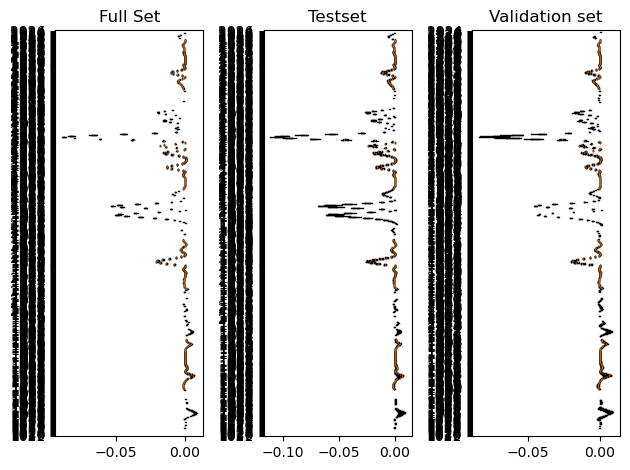

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
# fig, ( ax2, ax3) = plt.subplots(1,2)

ax1.boxplot(
    perm_results.importances.T, vert=False, labels=X.columns[perm_sorted_idx]
)

ax1.set_title("Full Set")

ax2.boxplot(
    perm_results_test.importances.T, vert=False, labels=X_test.columns[perm_sorted_test_idx]
)
#ax2.vline(x = 0, color = 'red')
ax2.set_title("Testset")

ax3.boxplot(
    perm_results_val.importances.T, vert=False, labels=X_val.columns[perm_sorted_val_idx]
)
#ax3.vline(x = 0, color = 'red')
ax3.set_title("Validation set")
fig.tight_layout()
plt.show()

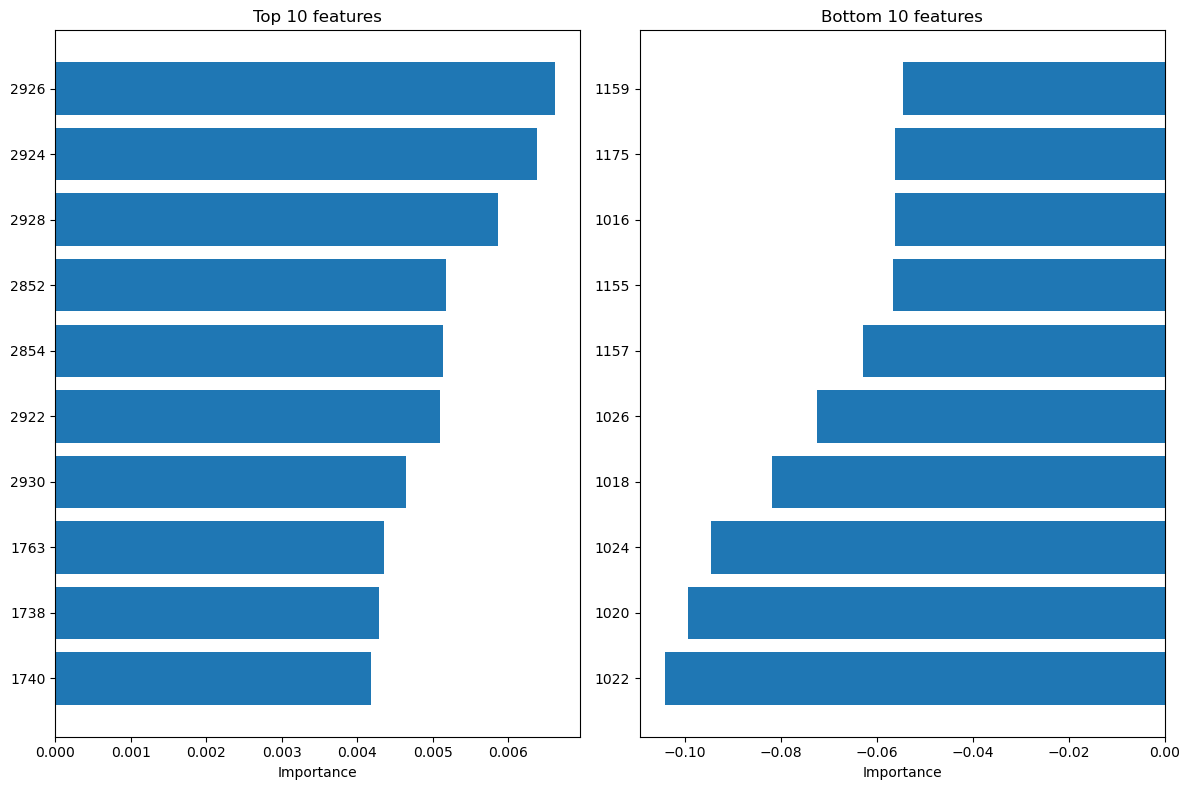

In [82]:
# reduce the figure to the top and bottom 10 features
top = 10
bottom = 10

fig, ( ax2, ax3) = plt.subplots(1,2, figsize = (12,8))
# get the top and bottom 10 features
perm_results_test_top = perm_results_test.importances_mean[perm_sorted_test_idx][-top:]
perm_results_test_bottom = perm_results_test.importances_mean[perm_sorted_test_idx][:bottom]
perm_results_test_top_idx = perm_sorted_test_idx[-top:]
perm_results_test_bottom_idx = perm_sorted_test_idx[:bottom]

# generate the plot
ax2.barh(X_test.columns[perm_results_test_top_idx], perm_results_test_top)
ax2.set_title(f"Top {top} features")
ax2.set_xlabel("Importance")
ax3.barh(X_test.columns[perm_results_test_bottom_idx], perm_results_test_bottom)
ax3.set_title(f"Bottom {bottom} features")
ax3.set_xlabel("Importance")
fig.tight_layout()


In [159]:
# Calculate the feature importance for clusters of 3, 5, 10, 20 features

# define the number of clusters
cluster_sizes = [1, 3, 5, 10, 20]

# define the number of repeats
n_repeats = 10

# define the number of jobs
n_jobs = 40

# define the random state
random_state = 12345

# define the dictionary to store the results
fi_clusters = {}
# loop over the clusters
for cluster_size in cluster_sizes:
    # create a new df from the original dataset
    X_cluster = X.copy()
    # drop every feature except every nth feature. where n is the cluster size
    X_cluster = X_cluster.iloc[:, ::cluster_size]
    # fit the model
    model_fi = KRR()
    model_fi.set_params(**param_dict)
    model_fi.fit(X_cluster, y)
    # calculate the permutation importance
    fi_cluster = permutation_importance(model_fi, X_cluster, y,
                               n_repeats=n_repeats,
                               random_state=random_state, 
                               n_jobs=n_jobs)
    # store the results in the dictionary
    fi_clusters[cluster_size] = fi_cluster


In [160]:
fi_cluster.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

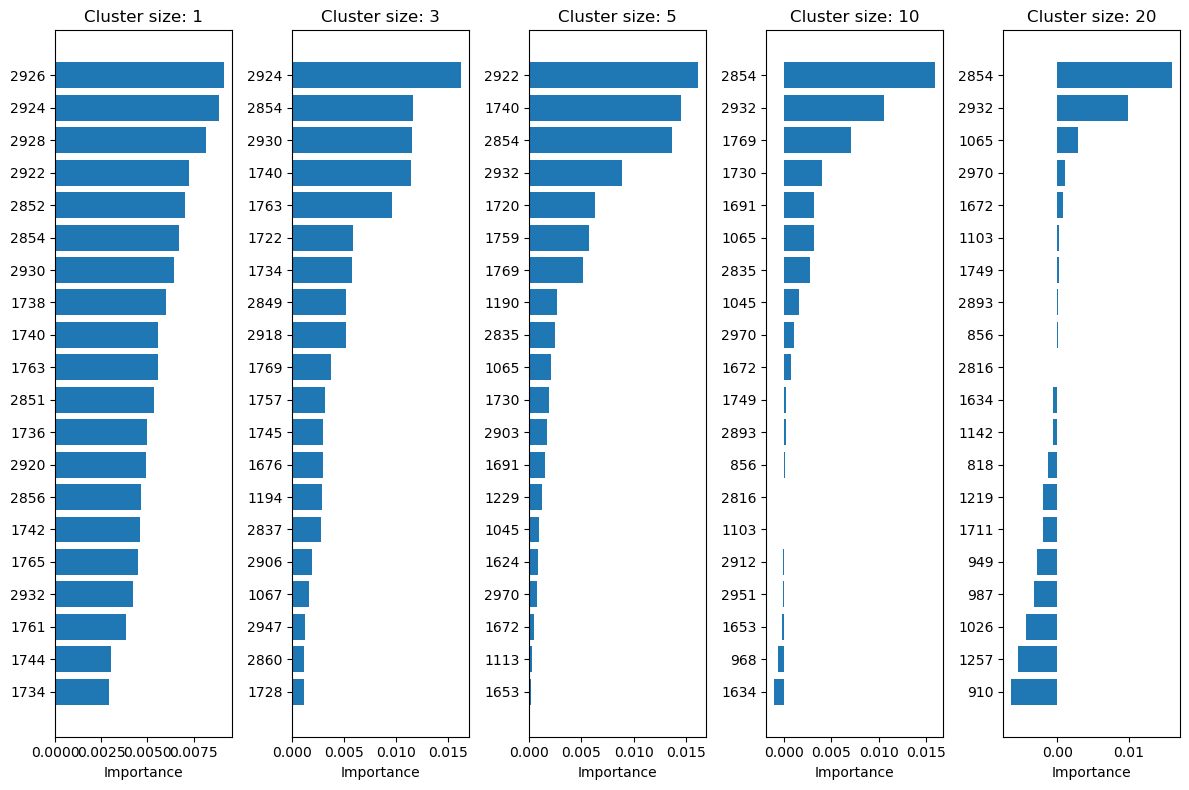

In [161]:
# Compare the results, by plotting the top 20 most important features for each cluster size

# define the number of top features to plot
top = 20

# define the number of clusters
n_clusters = len(cluster_sizes)

# create the figure
fig, ax = plt.subplots(1, n_clusters, figsize = (12,8))

# create a plot for each key in fi_cluster
for i, key in enumerate(fi_clusters.keys()):
    cluster_size = cluster_sizes[i]
    X_cluster = X.copy()
    X_cluster = X_cluster.iloc[:, ::cluster_size]
    # get the sorted index
    sorted_idx = fi_clusters[key].importances_mean.argsort()
    # get the top features
    top_idx = sorted_idx[-top:]
    # get the top importances
    top_importances = fi_clusters[key].importances_mean[top_idx]
    # get the top features
    top_features = X_cluster.columns[top_idx]
    # plot the top features
    ax[i].barh(top_features, top_importances)
    ax[i].set_title(f"Cluster size: {cluster_size}")
    ax[i].set_xlabel("Importance")
fig.tight_layout()
plt.show()

In [162]:
import matplotlib.pyplot as plt

# convert the feature names to integers
X_copy = X.copy()

#retrieve the name of the features
feature_names = X_copy.columns
feature_names = [int(name) for name in feature_names]
X_copy.columns = feature_names


In [182]:
n_clusters

1

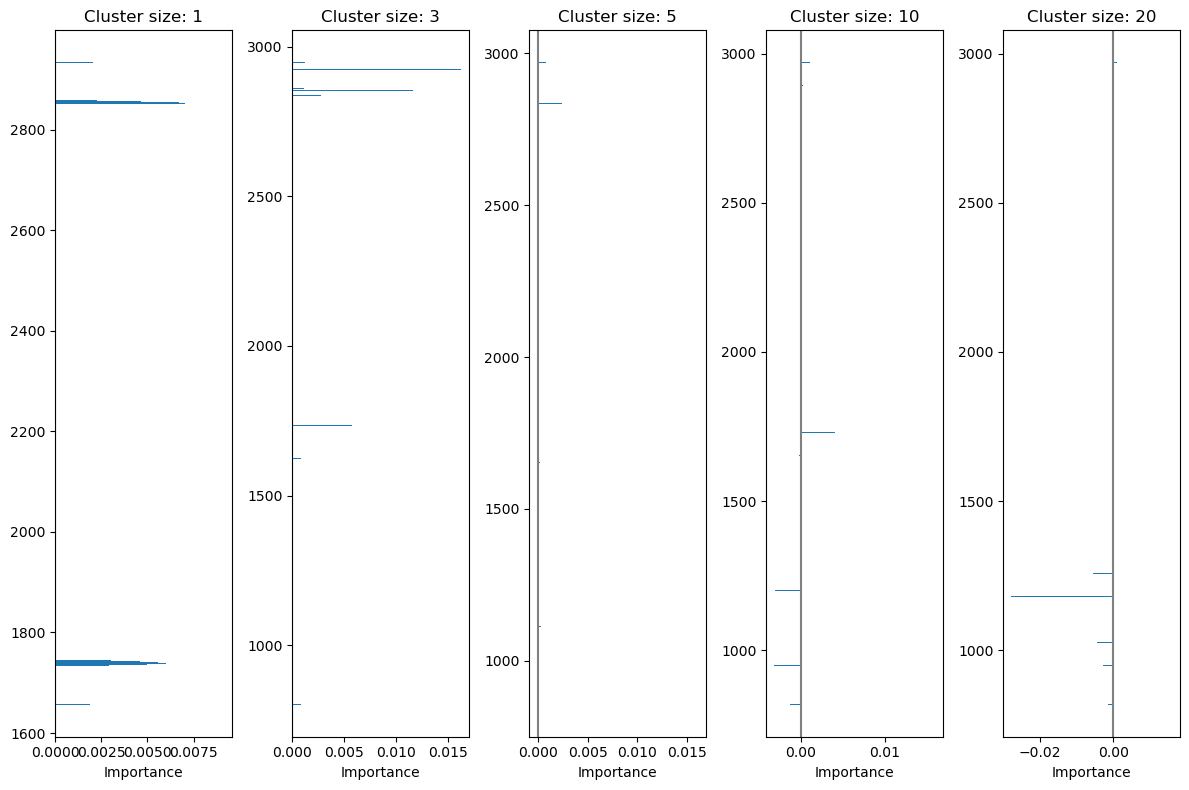

In [185]:
# define the number of top features to plot
top = 30

# define the number of clusters
n_clusters = len(cluster_sizes)

# create the figure
fig, ax = plt.subplots(1, n_clusters, figsize = (12,8))

# create a plot for each key in fi_cluster
for i, key in enumerate(fi_clusters.keys()):
    cluster_size = cluster_sizes[i]
    X_cluster = X.copy()
    X_cluster = X_cluster.iloc[:, ::cluster_size]
    # get the sorted index
    sorted_idx = fi_clusters[key].importances_mean.argsort()
    # get the top features
    top_idx = sorted_idx[-top:]
    # get the top importances
    top_importances = fi_clusters[key].importances_mean[top_idx]
    # get the top features
    top_features = X_cluster.columns[top_idx]
    # plot the top features
    top_features = [int(name) for name in top_features]
    ax[i].barh(top_features, top_importances)

    ax[i].set_title(f"Cluster size: {cluster_size}")
    ax[i].set_xlabel("Importance")
    # add a vertical line at 0
    ax[i].axvline(x=0, color="grey")
fig.tight_layout()
plt.show()

In [207]:
for i, key in enumerate(fi_clusters.keys()):

        print(i, key)

0 1
1 3
2 5
3 10
4 20


In [212]:
top_features

[1767,
 2918,
 1722,
 1720,
 2849,
 1734,
 1744,
 1761,
 2932,
 1765,
 1742,
 2856,
 2920,
 1736,
 2851,
 1763,
 1740,
 1738,
 2930,
 2854,
 2852,
 2922,
 2928,
 2924,
 2926]

[1767, 2918, 1722, 1720, 2849, 1734, 1744, 1761, 2932, 1765, 1742, 2856, 2920, 1736, 2851, 1763, 1740, 1738, 2930, 2854, 2852, 2922, 2928, 2924, 2926]


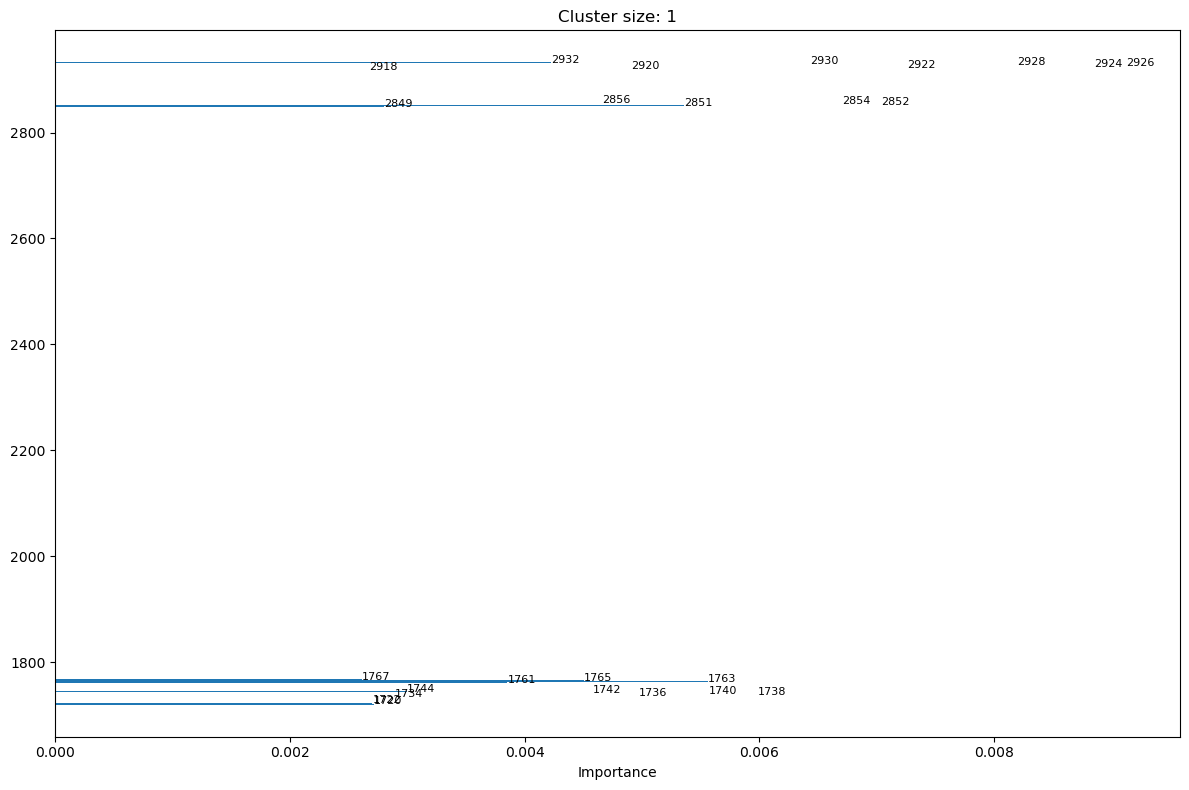

In [230]:
# define the number of top features to plot
top = 25

# define the number of clusters

# create the figure
fig, ax1 = plt.subplots(1, 1, figsize = (12,8))

# create a plot for each key in fi_cluster
for i, key in enumerate(fi_clusters.keys()):
    if key != 1: 
        continue
    else:
        skip = 1
    cluster_size = cluster_sizes[i]
    X_cluster = X.copy()
    X_cluster = X_cluster.iloc[:, ::cluster_size]
    # get the sorted index
    sorted_idx = fi_clusters[key].importances_mean.argsort()
    # get the top features
    top_idx = sorted_idx[-top:]
    # get the top importances
    top_importances = fi_clusters[key].importances_mean[top_idx]
    # get the top features
    top_features = X_cluster.columns[top_idx]
    # plot the top features
    top_features = [int(name) for name in top_features]
   
    ax1.barh(top_features, top_importances)
    for xi, yi, name in zip(top_importances, top_features, top_features):
        ax1.text(xi, yi, f"{name}", fontsize = 8)
    # ax1.bar_label(ax1.containers[1])
    ax1.set_title(f"Cluster size: {cluster_size}",)
    ax1.set_xlabel("Importance")
    print(top_features)

fig.tight_layout()
plt.show()

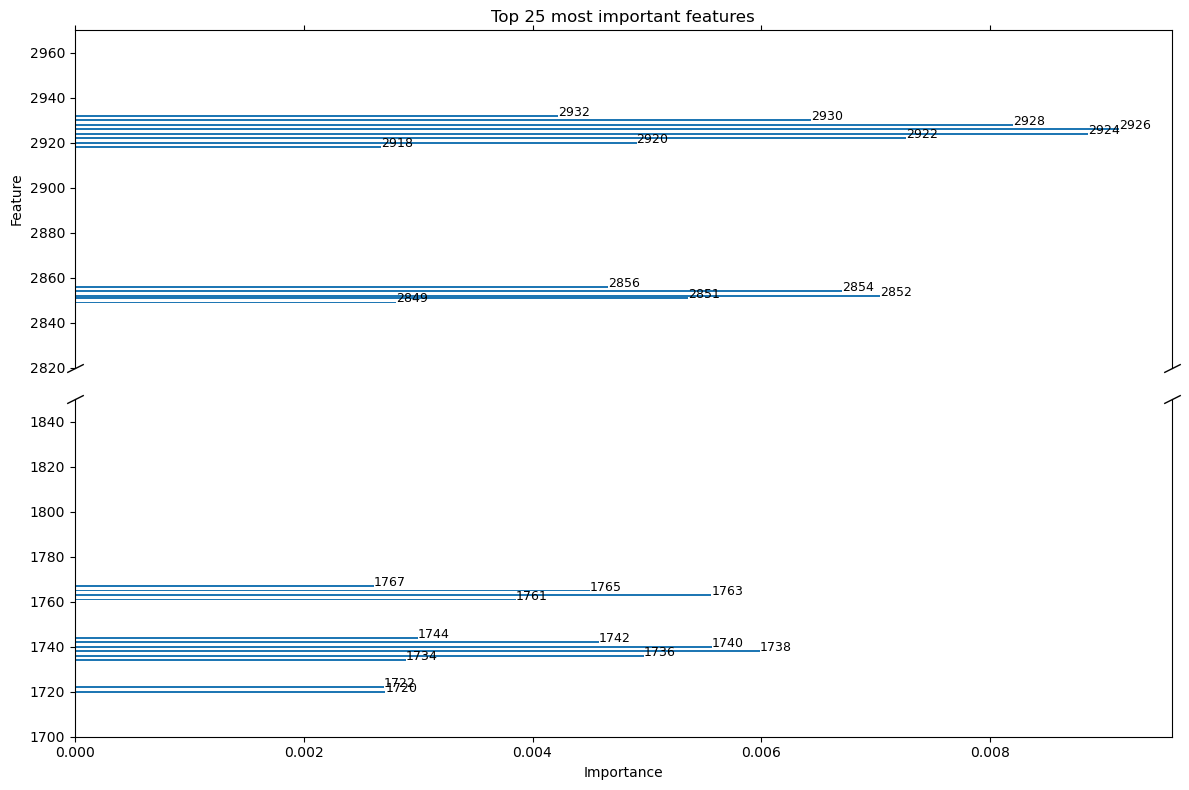

In [261]:
# create a plot with broken axis
top = 25

# define the number of clusters

# create the figure
fig, (ax1,ax2)= plt.subplots(2, 1, figsize = (12,8), sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# create a plot for each key in fi_cluster
for i, key in enumerate(fi_clusters.keys()):
    if key != 1: 
        continue
    else:
        skip = 1
    cluster_size = cluster_sizes[i]
    X_cluster = X.copy()
    X_cluster = X_cluster.iloc[:, ::cluster_size]
    # get the sorted index
    sorted_idx = fi_clusters[key].importances_mean.argsort()
    # get the top features
    top_idx = sorted_idx[-top:]
    # get the top importances
    top_importances = fi_clusters[key].importances_mean[top_idx]
    # get the top features
    top_features = X_cluster.columns[top_idx]
    # plot the top features
    top_features = [int(name) for name in top_features]
   
    ax1.barh(top_features, top_importances)
    ax1.set_ylim(2820, 2970)
    ax1.set_title(f"Top 25 most important features",)
    ax1.spines.bottom.set_visible(False)
    # ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax1.xaxis.tick_top()
    ax1.set_ylabel("Feature")


    for xi, yi, name in zip(top_importances, top_features, top_features):
        if yi > 2820:
            ax1.text(xi, yi, f"{name}", fontsize = 9)
        else:
            ax2.text(xi, yi, f"{name}", fontsize = 9)

    ax2.barh(top_features, top_importances)
    ax2.set_ylim(1700,1850)
    ax2.set_xlabel("Importance")
    ax2.spines.top.set_visible(False)
    ax2.xaxis.tick_bottom()
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "Top25_Features.png")
plt.show()

# write functions to perform feature importance calculation and visualisation in a automated way

In [262]:
def report_feature_importance(model, X, y, n_repeats = None, random_state = None, n_jobs = 30):
    """
    Function to report the feature importance for a given model
    """
    # calculate the permutation importance
    perm_results = permutation_importance(model, X, y,
                               n_repeats=n_repeats,
                               random_state=random_state, 
                               n_jobs=n_jobs)
    # get the sorted index
    sorted_idx = perm_results.importances_mean.argsort()
    # get the top features
    top_idx = sorted_idx[-top:]
    # get the top importances
    top_importances = perm_results.importances_mean[top_idx]
    # get the top features
    top_features = X.columns[top_idx]
    return top_features, top_importances

In [264]:
model = KRR()
params = params_krr
model.set_params(**params)
model.fit(X_train, y_train)
krr_top_features, krr_top_importances = report_feature_importance(model, X, y, n_repeats = 3, random_state = random_state, n_jobs = 30)

In [269]:
def plot_feature_importance2(top_features, top_importances, title, filename = None):
    """
    Function to plot the feature importance
    """
    fig, ax = plt.subplots(1, 1, figsize = (10,8))
    ax.barh(top_features, top_importances)
    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    fig.tight_layout()
    if filename != None:
        plt.savefig(FIGURE_PATH + filename)
    plt.show()

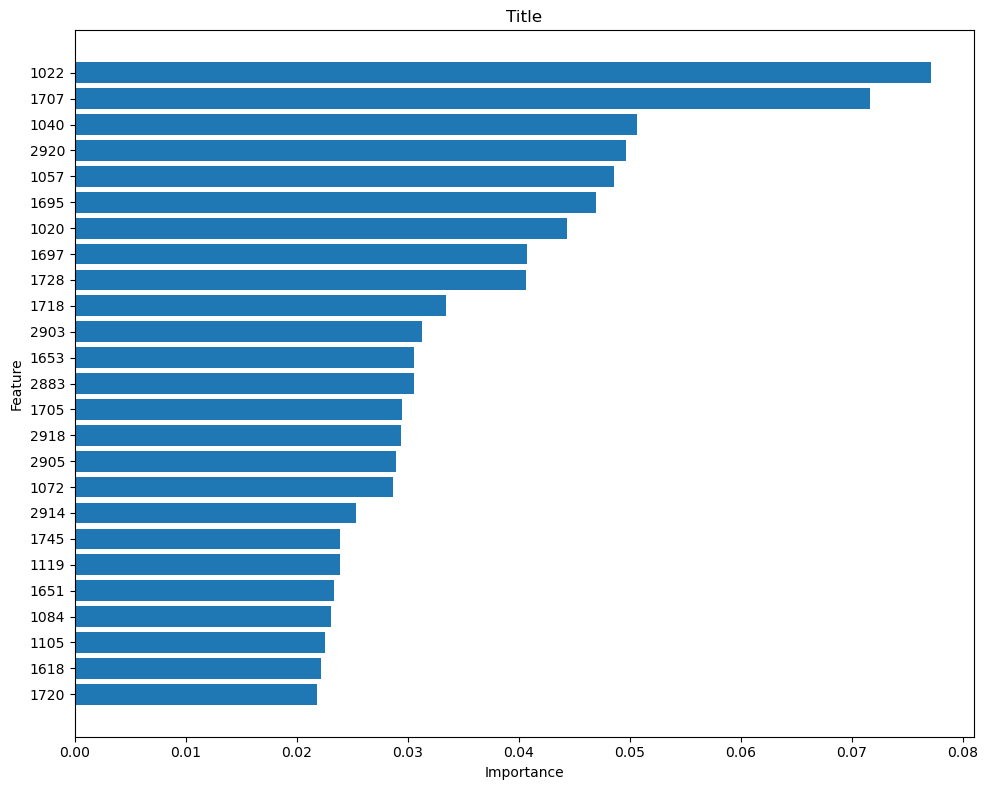

In [287]:
plot_feature_importance2(krr_top_features, krr_top_importances, "Title")